# Stacked Bar Charts (revised with better code!!!)
## Practice datawrangling and visualization with pandas and matplotlib
### dataset: tax data from Argentina

In [1]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import numpy as np
from matplotlib import rc
%matplotlib inline

## Data import and cleaning


In [2]:
# importing the data set with FECHA_PAGO as index, parse_date means we are using pandas' datetime function, datefirst adjusts for European date format
df = pd.read_csv('DEUDA_AUTO_DOS.csv', sep=',', encoding='utf-8', index_col='FECHA_PAGO', parse_dates=True, dayfirst=True)
df.dropna(axis='columns', how='all', inplace=True)

In [3]:
df.head()

,MCC_OBN_ID,MCC_TIPO_MOVIMIENTO,MCC_IMPORTE,MCC_TIPO_ORIGEN,MCC_CCC_ID,MCC_FECHA_MOVIMIENTO,OBN_PERIODO,OBN_CUOTA,OBN_TIPO_OBJETO_ID,OBN_OBJETO_ID,FECHA_PROCESO,OBJETO
FECHA_PAGO,,,,,,,,,,,,
NaT,20150000000020310940,D,713.66,FAO,130,06/10/2017,2015.0,10.0,A,7803962.0,05/06/2019,KUJ808
NaT,20150000000020310940,C,813.75,FAO,CPP,06/10/2017,2015.0,10.0,A,7803962.0,05/06/2019,KUJ808
NaT,20150000000020310940,C,713.66,FAO,CPI,06/10/2017,2015.0,10.0,A,7803962.0,05/06/2019,KUJ808
NaT,20150000000020310940,D,813.75,NaN,600,13/05/2015,2015.0,10.0,A,7803962.0,05/06/2019,KUJ808
NaT,20180000000020997023,D,565.84,NaN,600,10/08/2018,2018.0,30.0,A,8970196.0,05/06/2019,PBS192


In [4]:
# add a new column called "Period" with the year-month format
df['Period'] = df.index.to_period(freq='M')
# We only want origen (PAO)
df = df.copy()[df["MCC_TIPO_ORIGEN"]=="PAO"]
# We only want tipo C (credito)
df = df[df['MCC_TIPO_MOVIMIENTO']=="C"]
# drop unnecessary columns
clean_df = df.drop(['MCC_TIPO_MOVIMIENTO','MCC_TIPO_ORIGEN','MCC_CCC_ID','MCC_FECHA_MOVIMIENTO','OBN_PERIODO','OBN_TIPO_OBJETO_ID','OBN_OBJETO_ID','FECHA_PROCESO','OBJETO'], axis=1)
# git rid of this annoying decimal in the name of the cuotas
clean_df['OBN_CUOTA'] = clean_df.OBN_CUOTA.astype(int)
clean_df.tail()

,MCC_OBN_ID,MCC_IMPORTE,OBN_CUOTA,Period
FECHA_PAGO,,,,
2019-05-17,20190000000037232721,14.36,3,2019-05
2017-02-13,20170000000014132060,2330.37,0,2017-02
2015-06-30,20140000000020327824,102.09,20,2015-06
2015-06-30,20140000000020327824,356.95,20,2015-06
2016-10-04,20160000000030916612,832.87,90,2016-10


In [5]:
#there are many more, 19, cuota types now 
clean_df['OBN_CUOTA'].unique()

array([ 3,  0,  4,  9,  1,  6, 10, 90,  7,  2,  8, 40, 20, 30, 50,  5, 12,
       11, 51])

In [6]:
#don't run this. It's just for saving to csv
#clean_df.to_csv('clean_payments.csv')

In [7]:
clean_df.head()

,MCC_OBN_ID,MCC_IMPORTE,OBN_CUOTA,Period
FECHA_PAGO,,,,
2019-04-10,20190000000030211407,655.52,3,2019-04
2019-01-15,20190000000032832543,2326.27,0,2019-01
2019-05-10,20190000000034011507,210.73,4,2019-05
2019-05-23,20190000000035197532,634.13,9,2019-05
2019-04-22,20190000000036404391,598.13,3,2019-04


In [8]:
indexed = clean_df.set_index('Period') # change index to "Period" (month + year)
cuota_group = indexed.groupby('OBN_CUOTA')

## Class dataframing by cuota

In [9]:
class dataframing():
    
    """This class takes our tax payment data and rearranges it into one large dataframe grouped by monthly sums for each cuota (payment category).
       Executing the dataframes_by_cuota to make the magic happen."""

    def __init__(self):
        print("datawrangling...")
        
    
    def dataframes_by_cuota(self, my_data_frame):
        combine = {}
        df_list = []
        for i in my_data_frame['OBN_CUOTA'].unique(): 
            y = float(i)
            x = my_data_frame.get_group(y)
            string = str(i)
            nombre = string[1:-1]
            new_name = 'Cuota_'+nombre
            x.rename(index=str, columns={"MCC_IMPORTE":new_name}, inplace=True)
            x_series = x.groupby('Period').sum() # sum by month (period) and cuota
            x_series = x_series.iloc[:,:1] # this just gets rid of the 'OBN_CUOTA' column that we don't need anymore
            df_list.append(x_series)
            
            merged = None # merge the new dataframes into one large dataframe
            for data in df_list:
                if merged is None:
                    merged = data
                    continue
                else:
                    merged = pd.merge(merged, data, on='Period', how='outer')
        print("Finished!")
        return merged        

In [10]:
timeseries_practice = dataframing() # initiate the class
new_df = timeseries_practice.dataframes_by_cuota(cuota_group).sort_index()

datawrangling...


/anaconda3/envs/diplodatos-ayv/lib/python3.5/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


Finished!


In [11]:
# data frame of sums
new_df.head()

,Cuota_0,Cuota_1,Cuota_2,Cuota_3,Cuota_4,Cuota_5,Cuota_6,Cuota_7,Cuota_8,Cuota_9,Cuota_10,Cuota_11,Cuota_12,Cuota_20,Cuota_30,Cuota_40,Cuota_50,Cuota_51,Cuota_90
Period,,,,,,,,,,,,,,,,,,,
2012-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2538.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,861.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-04,2068.84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-05,8554.77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5449.14,NaN,NaN,658.75,NaN,NaN,NaN,NaN,NaN
2012-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,585.86,NaN,NaN,1780.95,NaN,NaN,NaN,NaN,NaN


# Making stacked bar charts of sums 

## first chart: all information (sums by month,  2014-2019)

### NOTE: I have drawn the "new" cuota types in black so you it is easier to compare 

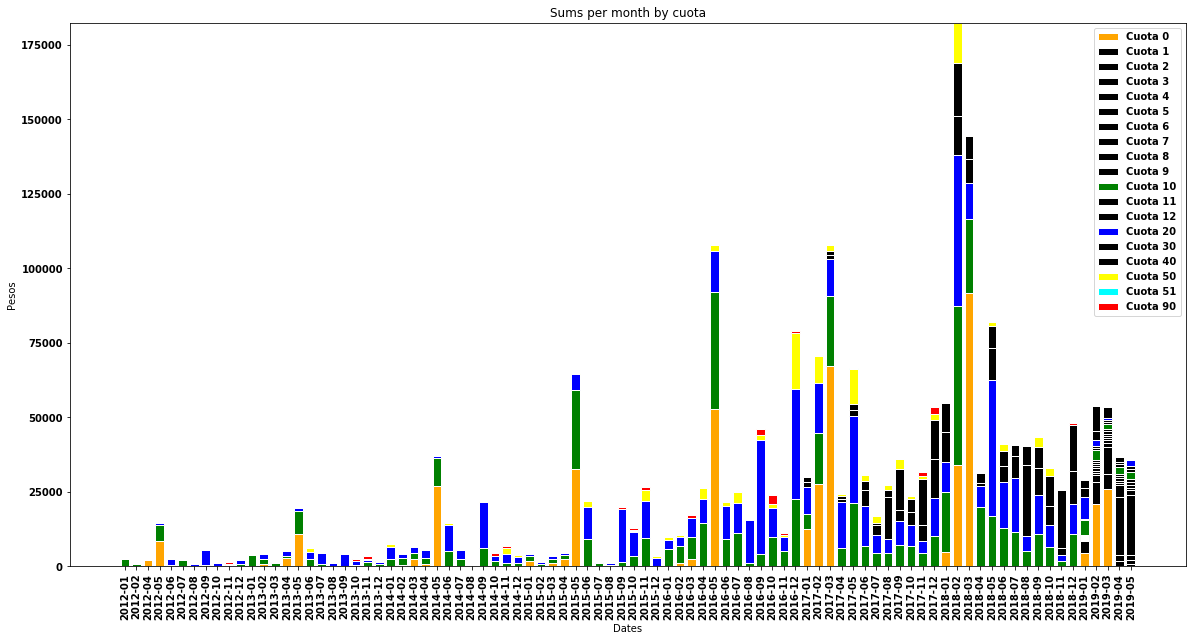

In [12]:
# figure size
plt.rcParams['figure.figsize'] = [20, 10]
# y-axis in bold
rc('font', weight='bold')

# Heights
indx = new_df.index.astype(str)
bar0 = new_df.Cuota_0.fillna(0)
bar1 = new_df.Cuota_1.fillna(0)
bar2 = new_df.Cuota_2.fillna(0)
bar3 = new_df.Cuota_3.fillna(0)
bar4 = new_df.Cuota_4.fillna(0)
bar5 = new_df.Cuota_5.fillna(0)
bar6 = new_df.Cuota_6.fillna(0)
bar7 = new_df.Cuota_7.fillna(0)
bar8 = new_df.Cuota_8.fillna(0)
bar9 = new_df.Cuota_9.fillna(0)
bar10 = new_df.Cuota_10.fillna(0)
bar11 = new_df.Cuota_11.fillna(0)
bar12 = new_df.Cuota_12.fillna(0)
bar20 = new_df.Cuota_20.fillna(0)
bar30 = new_df.Cuota_30.fillna(0)
bar40 = new_df.Cuota_40.fillna(0)
bar50 = new_df.Cuota_50.fillna(0)
bar51 = new_df.Cuota_51.fillna(0)
bar90 = new_df.Cuota_90.fillna(0) 
 
# Names of group and bar width
names = indx
barWidth = 0.75
 
# Create orange bars
p1 = plt.bar(indx, bar0, color='orange', edgecolor='white', width=barWidth)
# Create black bars (middle), on top of the first ones
p2 = plt.bar(indx, bar1, bottom=bar0, color='black', edgecolor='white', width=barWidth)
# Create black bars (middle)
p3 = plt.bar(indx, bar2, bottom=bar1+bar0, color='black', edgecolor='white', width=barWidth)
# Create black bars (middle)
p4 = plt.bar(indx, bar3, bottom=bar2+bar1+bar0, color='black', edgecolor='white', width=barWidth)
# Create black bars (middle)
p5 = plt.bar(indx, bar4, bottom=bar3+bar2+bar1+bar0, color='black', edgecolor='white', width=barWidth)
# Create black bars (top)
p6 = plt.bar(indx, bar5, bottom=bar4+bar3+bar2+bar1+bar0, color='black', edgecolor='white', width=barWidth)
# Create black bars (top)
p7 = plt.bar(indx, bar6, bottom=bar5+bar4+bar3+bar2+bar1+bar0, color='black', edgecolor='white', width=barWidth)
# Create black bars (top)
p8 = plt.bar(indx, bar7, bottom=bar6+bar5+bar4+bar3+bar2+bar1+bar0, color='black', edgecolor='white', width=barWidth)
# Create black bars (top)
p9 = plt.bar(indx, bar8, bottom=bar7+bar6+bar5+bar4+bar3+bar2+bar1+bar0, color='black', edgecolor='white', width=barWidth)
# Create black bars (top)
p10 = plt.bar(indx, bar9, bottom=bar8+bar7+bar6+bar5+bar4+bar3+bar2+bar1+bar0, color='black', edgecolor='white', width=barWidth)
# Create green bars (top)
p11 = plt.bar(indx, bar10, bottom=bar9+bar8+bar7+bar6+bar5+bar4+bar3+bar2+bar1+bar0, color='green', edgecolor='white', width=barWidth)
# Create black bars (top)
p12 = plt.bar(indx, bar11, bottom=bar10+bar9+bar8+bar7+bar6+bar5+bar4+bar3+bar2+bar1+bar0, color='black', edgecolor='white', width=barWidth)
# Create black bars (top)
p13 = plt.bar(indx, bar12, bottom=bar11+bar10+bar9+bar8+bar7+bar6+bar5+bar4+bar3+bar2+bar1+bar0, color='black', edgecolor='white', width=barWidth)
# Create blue bars (top)
p14 = plt.bar(indx, bar20, bottom=bar12+bar11+bar10+bar9+bar8+bar7+bar6+bar5+bar4+bar3+bar2+bar1+bar0, color='blue', edgecolor='white', width=barWidth)
# Create black bars (top)
p15 = plt.bar(indx, bar30, bottom=bar20+bar12+bar11+bar10+bar9+bar8+bar7+bar6+bar5+bar4+bar3+bar2+bar1+bar0, color='black', edgecolor='white', width=barWidth)
# Create black bars (top)
p16 = plt.bar(indx, bar40, bottom=bar30+bar20+bar12+bar11+bar10+bar9+bar8+bar7+bar6+bar5+bar4+bar3+bar2+bar1+bar0, color='black', edgecolor='white', width=barWidth)
# Create yellow bars (top)
p17 = plt.bar(indx, bar50, bottom=bar40+bar30+bar20+bar12+bar11+bar10+bar9+bar8+bar7+bar6+bar5+bar4+bar3+bar2+bar1+bar0, color="yellow", edgecolor='white', width=barWidth)
# Create cyan bars (top)
p18 = plt.bar(indx, bar51, bottom=bar50+bar40+bar30+bar20+bar12+bar11+bar10+bar9+bar8+bar7+bar6+bar5+bar4+bar3+bar2+bar1+bar0, color='cyan', edgecolor='white', width=barWidth)
# Create red bars (top)
p19 = plt.bar(indx, bar90, bottom=bar51+bar50+bar40+bar30+bar20+bar12+bar11+bar10+bar9+bar8+bar7+bar6+bar5+bar4+bar3+bar2+bar1+bar0, color='red', edgecolor='white', width=barWidth)

plt.ylabel('Pesos')
plt.title('Sums per month by cuota')
# Custom X axis
plt.xlabel('Dates')
plt.ylabel('Pesos')
plt.xticks(indx, rotation=90)
plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0], p6[0], p7[0], p8[0], p9[0], p10[0], p11[0], p12[0], p13[0], p14[0], p15[0], p16[0], p17[0], p18[0], p19[0]), ('Cuota 0', 'Cuota 1', 'Cuota 2', 'Cuota 3', 'Cuota 4', 'Cuota 5', 'Cuota 6', 'Cuota 7', 'Cuota 8', 'Cuota 9', 'Cuota 10', 'Cuota 11', 'Cuota 12', 'Cuota 20', 'Cuota 30', 'Cuota 40', 'Cuota 50', 'Cuota 51', 'Cuota 90'))
# Show graphic
plt.show()

### Question #1: Why are there payments in 2012?
### Question #2: There seems to be a high frequency pattern of cuota 0 payments made in May of each year until 2017. What's that about?

# SUMS 2016

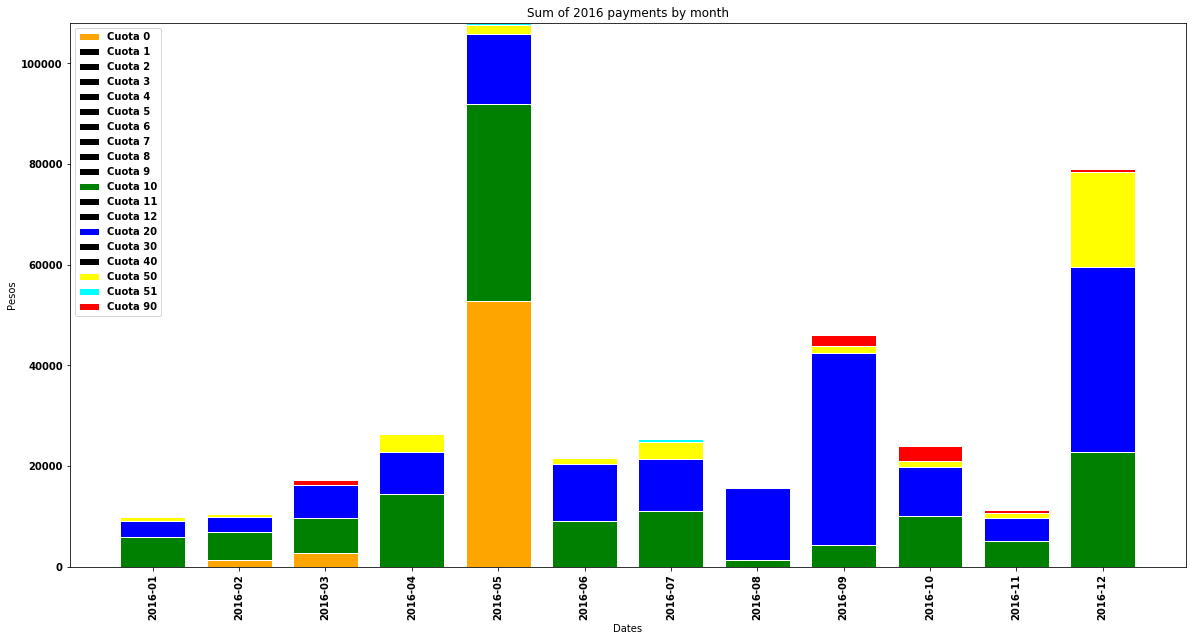

In [13]:
# Stacked bar chart for 2016
plt.rcParams['figure.figsize'] = [20,10]
# y-axis in bol
rc('font', weight='bold')

df_2016 = new_df['2016-01':'2016-12']
# heights
indx = df_2016.index.astype(str)
bar0 = df_2016.Cuota_0.fillna(0)
bar1 = df_2016.Cuota_1.fillna(0)
bar2 = df_2016.Cuota_2.fillna(0)
bar3 = df_2016.Cuota_3.fillna(0)
bar4 = df_2016.Cuota_4.fillna(0)
bar5 = df_2016.Cuota_5.fillna(0)
bar6 = df_2016.Cuota_6.fillna(0)
bar7 = df_2016.Cuota_7.fillna(0)
bar8 = df_2016.Cuota_8.fillna(0)
bar9 = df_2016.Cuota_9.fillna(0)
bar10 = df_2016.Cuota_10.fillna(0)
bar11 = df_2016.Cuota_11.fillna(0)
bar12 = df_2016.Cuota_12.fillna(0)
bar20 = df_2016.Cuota_20.fillna(0)
bar30 = df_2016.Cuota_30.fillna(0)
bar40 = df_2016.Cuota_40.fillna(0)
bar50 = df_2016.Cuota_50.fillna(0)
bar51 = df_2016.Cuota_51.fillna(0)
bar90 = df_2016.Cuota_90.fillna(0)  

# Names of group and bar width
names = indx
barWidth = 0.75
 
# Create orange bars
p1 = plt.bar(indx, bar0, color='orange', edgecolor='white', width=barWidth)
# Create black bars (middle), on top of the first ones
p2 = plt.bar(indx, bar1, bottom=bar0, color='black', edgecolor='white', width=barWidth)
# Create black bars (middle)
p3 = plt.bar(indx, bar2, bottom=bar1+bar0, color='black', edgecolor='white', width=barWidth)
# Create black bars (middle)
p4 = plt.bar(indx, bar3, bottom=bar2+bar1+bar0, color='black', edgecolor='white', width=barWidth)
# Create black bars (middle)
p5 = plt.bar(indx, bar4, bottom=bar3+bar2+bar1+bar0, color='black', edgecolor='white', width=barWidth)
# Create black bars (top)
p6 = plt.bar(indx, bar5, bottom=bar4+bar3+bar2+bar1+bar0, color='black', edgecolor='white', width=barWidth)
# Create black bars (top)
p7 = plt.bar(indx, bar6, bottom=bar5+bar4+bar3+bar2+bar1+bar0, color='black', edgecolor='white', width=barWidth)
# Create black bars (top)
p8 = plt.bar(indx, bar7, bottom=bar6+bar5+bar4+bar3+bar2+bar1+bar0, color='black', edgecolor='white', width=barWidth)
# Create black bars (top)
p9 = plt.bar(indx, bar8, bottom=bar7+bar6+bar5+bar4+bar3+bar2+bar1+bar0, color='black', edgecolor='white', width=barWidth)
# Create black bars (top)
p10 = plt.bar(indx, bar9, bottom=bar8+bar7+bar6+bar5+bar4+bar3+bar2+bar1+bar0, color='black', edgecolor='white', width=barWidth)
# Create green bars (top)
p11 = plt.bar(indx, bar10, bottom=bar9+bar8+bar7+bar6+bar5+bar4+bar3+bar2+bar1+bar0, color='green', edgecolor='white', width=barWidth)
# Create black bars (top)
p12 = plt.bar(indx, bar11, bottom=bar10+bar9+bar8+bar7+bar6+bar5+bar4+bar3+bar2+bar1+bar0, color='black', edgecolor='white', width=barWidth)
# Create black bars (top)
p13 = plt.bar(indx, bar12, bottom=bar11+bar10+bar9+bar8+bar7+bar6+bar5+bar4+bar3+bar2+bar1+bar0, color='black', edgecolor='white', width=barWidth)
# Create blue bars (top)
p14 = plt.bar(indx, bar20, bottom=bar12+bar11+bar10+bar9+bar8+bar7+bar6+bar5+bar4+bar3+bar2+bar1+bar0, color='blue', edgecolor='white', width=barWidth)
# Create black bars (top)
p15 = plt.bar(indx, bar30, bottom=bar20+bar12+bar11+bar10+bar9+bar8+bar7+bar6+bar5+bar4+bar3+bar2+bar1+bar0, color='black', edgecolor='white', width=barWidth)
# Create black bars (top)
p16 = plt.bar(indx, bar40, bottom=bar30+bar20+bar12+bar11+bar10+bar9+bar8+bar7+bar6+bar5+bar4+bar3+bar2+bar1+bar0, color='black', edgecolor='white', width=barWidth)
# Create yellow bars (top)
p17 = plt.bar(indx, bar50, bottom=bar40+bar30+bar20+bar12+bar11+bar10+bar9+bar8+bar7+bar6+bar5+bar4+bar3+bar2+bar1+bar0, color="yellow", edgecolor='white', width=barWidth)
# Create cyan bars (top)
p18 = plt.bar(indx, bar51, bottom=bar50+bar40+bar30+bar20+bar12+bar11+bar10+bar9+bar8+bar7+bar6+bar5+bar4+bar3+bar2+bar1+bar0, color='cyan', edgecolor='white', width=barWidth)
# Create red bars (top)
p19 = plt.bar(indx, bar90, bottom=bar51+bar50+bar40+bar30+bar20+bar12+bar11+bar10+bar9+bar8+bar7+bar6+bar5+bar4+bar3+bar2+bar1+bar0, color='red', edgecolor='white', width=barWidth)


# label axes
plt.ylabel('Pesos')
plt.xlabel('Dates')
plt.title('Sum of 2016 payments by month')
# rotate X axis label
plt.xticks(indx, rotation=90)
plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0], p6[0], p7[0], p8[0], p9[0], p10[0], p11[0], p12[0], p13[0], p14[0], p15[0], p16[0], p17[0], p18[0], p19[0]), ('Cuota 0', 'Cuota 1', 'Cuota 2', 'Cuota 3', 'Cuota 4', 'Cuota 5', 'Cuota 6', 'Cuota 7', 'Cuota 8', 'Cuota 9', 'Cuota 10', 'Cuota 11', 'Cuota 12', 'Cuota 20', 'Cuota 30', 'Cuota 40', 'Cuota 50', 'Cuota 51', 'Cuota 90'))
# Show graphic
plt.show()

# SUMS 2017

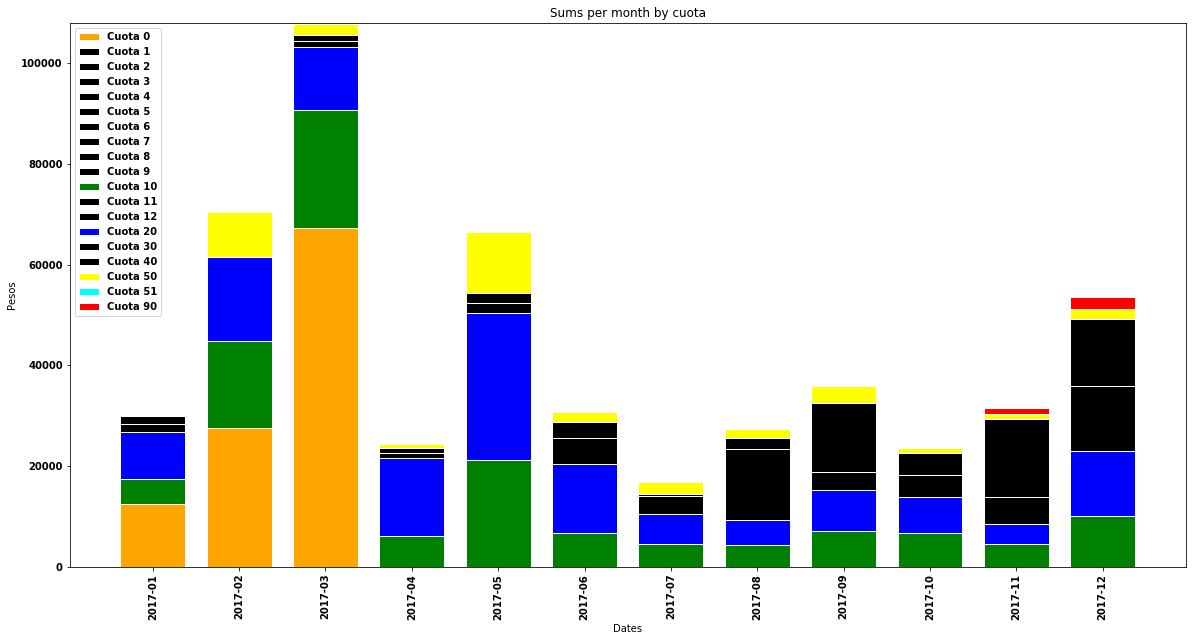

In [14]:
# figure size
plt.rcParams['figure.figsize'] = [20, 10]
# y-axis in bold
rc('font', weight='bold')

df_2017 = new_df['2017-01':'2017-12']

# Heights
indx = df_2017.index.astype(str)
bar0 = df_2017.Cuota_0.fillna(0)
bar1 = df_2017.Cuota_1.fillna(0)
bar2 = df_2017.Cuota_2.fillna(0)
bar3 = df_2017.Cuota_3.fillna(0)
bar4 = df_2017.Cuota_4.fillna(0)
bar5 = df_2017.Cuota_5.fillna(0)
bar6 = df_2017.Cuota_6.fillna(0)
bar7 = df_2017.Cuota_7.fillna(0)
bar8 = df_2017.Cuota_8.fillna(0)
bar9 = df_2017.Cuota_9.fillna(0)
bar10 = df_2017.Cuota_10.fillna(0)
bar11 = df_2017.Cuota_11.fillna(0)
bar12 = df_2017.Cuota_12.fillna(0)
bar20 = df_2017.Cuota_20.fillna(0)
bar30 = df_2017.Cuota_30.fillna(0)
bar40 = df_2017.Cuota_40.fillna(0)
bar50 = df_2017.Cuota_50.fillna(0)
bar51 = df_2017.Cuota_51.fillna(0)
bar90 = df_2017.Cuota_90.fillna(0)
 
# Names of group and bar width
names = indx
barWidth = 0.75
 
# Create orange bars
p1 = plt.bar(indx, bar0, color='orange', edgecolor='white', width=barWidth)
# Create black bars (middle), on top of the first ones
p2 = plt.bar(indx, bar1, bottom=bar0, color='black', edgecolor='white', width=barWidth)
# Create black bars (middle)
p3 = plt.bar(indx, bar2, bottom=bar1+bar0, color='black', edgecolor='white', width=barWidth)
# Create black bars (middle)
p4 = plt.bar(indx, bar3, bottom=bar2+bar1+bar0, color='black', edgecolor='white', width=barWidth)
# Create black bars (middle)
p5 = plt.bar(indx, bar4, bottom=bar3+bar2+bar1+bar0, color='black', edgecolor='white', width=barWidth)
# Create black bars (top)
p6 = plt.bar(indx, bar5, bottom=bar4+bar3+bar2+bar1+bar0, color='black', edgecolor='white', width=barWidth)
# Create black bars (top)
p7 = plt.bar(indx, bar6, bottom=bar5+bar4+bar3+bar2+bar1+bar0, color='black', edgecolor='white', width=barWidth)
# Create black bars (top)
p8 = plt.bar(indx, bar7, bottom=bar6+bar5+bar4+bar3+bar2+bar1+bar0, color='black', edgecolor='white', width=barWidth)
# Create black bars (top)
p9 = plt.bar(indx, bar8, bottom=bar7+bar6+bar5+bar4+bar3+bar2+bar1+bar0, color='black', edgecolor='white', width=barWidth)
# Create black bars (top)
p10 = plt.bar(indx, bar9, bottom=bar8+bar7+bar6+bar5+bar4+bar3+bar2+bar1+bar0, color='black', edgecolor='white', width=barWidth)
# Create green bars (top)
p11 = plt.bar(indx, bar10, bottom=bar9+bar8+bar7+bar6+bar5+bar4+bar3+bar2+bar1+bar0, color='green', edgecolor='white', width=barWidth)
# Create black bars (top)
p12 = plt.bar(indx, bar11, bottom=bar10+bar9+bar8+bar7+bar6+bar5+bar4+bar3+bar2+bar1+bar0, color='black', edgecolor='white', width=barWidth)
# Create black bars (top)
p13 = plt.bar(indx, bar12, bottom=bar11+bar10+bar9+bar8+bar7+bar6+bar5+bar4+bar3+bar2+bar1+bar0, color='black', edgecolor='white', width=barWidth)
# Create blue bars (top)
p14 = plt.bar(indx, bar20, bottom=bar12+bar11+bar10+bar9+bar8+bar7+bar6+bar5+bar4+bar3+bar2+bar1+bar0, color='blue', edgecolor='white', width=barWidth)
# Create black bars (top)
p15 = plt.bar(indx, bar30, bottom=bar20+bar12+bar11+bar10+bar9+bar8+bar7+bar6+bar5+bar4+bar3+bar2+bar1+bar0, color='black', edgecolor='white', width=barWidth)
# Create black bars (top)
p16 = plt.bar(indx, bar40, bottom=bar30+bar20+bar12+bar11+bar10+bar9+bar8+bar7+bar6+bar5+bar4+bar3+bar2+bar1+bar0, color='black', edgecolor='white', width=barWidth)
# Create yellow bars (top)
p17 = plt.bar(indx, bar50, bottom=bar40+bar30+bar20+bar12+bar11+bar10+bar9+bar8+bar7+bar6+bar5+bar4+bar3+bar2+bar1+bar0, color="yellow", edgecolor='white', width=barWidth)
# Create cyan bars (top)
p18 = plt.bar(indx, bar51, bottom=bar50+bar40+bar30+bar20+bar12+bar11+bar10+bar9+bar8+bar7+bar6+bar5+bar4+bar3+bar2+bar1+bar0, color='cyan', edgecolor='white', width=barWidth)
# Create red bars (top)
p19 = plt.bar(indx, bar90, bottom=bar51+bar50+bar40+bar30+bar20+bar12+bar11+bar10+bar9+bar8+bar7+bar6+bar5+bar4+bar3+bar2+bar1+bar0, color='red', edgecolor='white', width=barWidth)



plt.ylabel('Pesos')
plt.title('Sums per month by cuota')
# Custom X axis
plt.xlabel('Dates')
plt.ylabel('Pesos')
plt.xticks(indx, rotation=90)
plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0], p6[0], p7[0], p8[0], p9[0], p10[0], p11[0], p12[0], p13[0], p14[0], p15[0], p16[0], p17[0], p18[0], p19[0]), ('Cuota 0', 'Cuota 1', 'Cuota 2', 'Cuota 3', 'Cuota 4', 'Cuota 5', 'Cuota 6', 'Cuota 7', 'Cuota 8', 'Cuota 9', 'Cuota 10', 'Cuota 11', 'Cuota 12', 'Cuota 20', 'Cuota 30', 'Cuota 40', 'Cuota 50', 'Cuota 51', 'Cuota 90'))
# Show graphic
plt.show()

# SUMS 2018

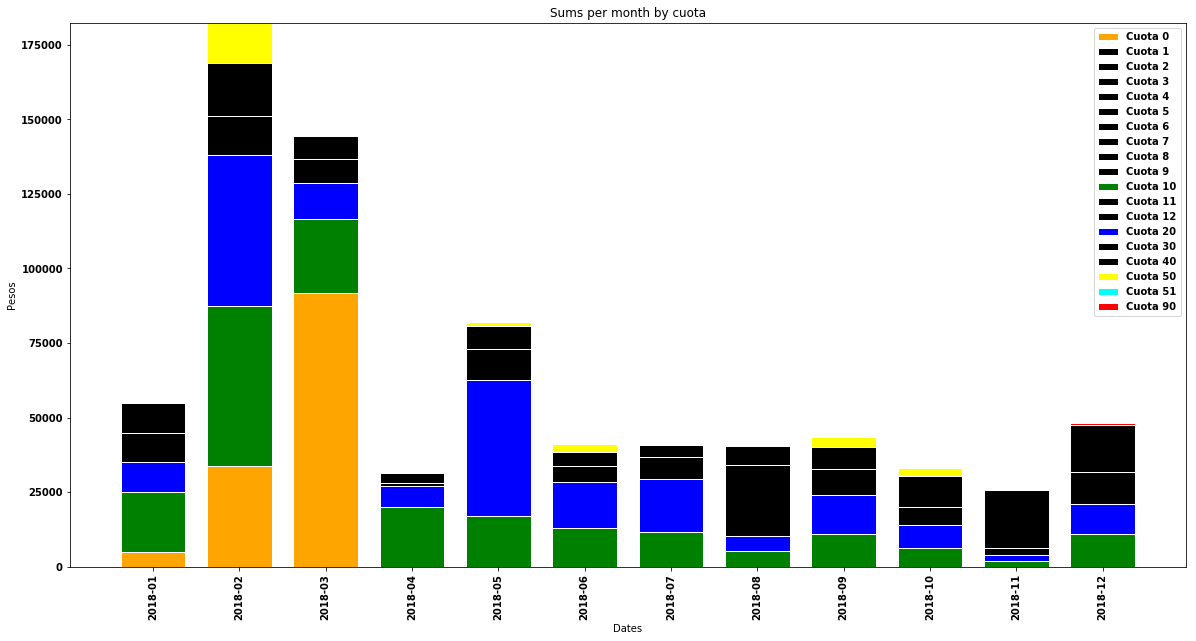

In [15]:
# figure size
plt.rcParams['figure.figsize'] = [20, 10]
# y-axis in bold
rc('font', weight='bold')

df_2018 = new_df['2018-01':'2018-12']

# Heights
indx = df_2018.index.astype(str)
bar0 = df_2018.Cuota_0.fillna(0)
bar1 = df_2018.Cuota_1.fillna(0)
bar2 = df_2018.Cuota_2.fillna(0)
bar3 = df_2018.Cuota_3.fillna(0)
bar4 = df_2018.Cuota_4.fillna(0)
bar5 = df_2018.Cuota_5.fillna(0)
bar6 = df_2018.Cuota_6.fillna(0)
bar7 = df_2018.Cuota_7.fillna(0)
bar8 = df_2018.Cuota_8.fillna(0)
bar9 = df_2018.Cuota_9.fillna(0)
bar10 = df_2018.Cuota_10.fillna(0)
bar11 = df_2018.Cuota_11.fillna(0)
bar12 = df_2018.Cuota_12.fillna(0)
bar20 = df_2018.Cuota_20.fillna(0)
bar30 = df_2018.Cuota_30.fillna(0)
bar40 = df_2018.Cuota_40.fillna(0)
bar50 = df_2018.Cuota_50.fillna(0)
bar51 = df_2018.Cuota_51.fillna(0)
bar90 = df_2018.Cuota_90.fillna(0) 
 
# Names of group and bar width
names = indx
barWidth = 0.75
 
# Create orange bars
p1 = plt.bar(indx, bar0, color='orange', edgecolor='white', width=barWidth)
# Create black bars (middle), on top of the first ones
p2 = plt.bar(indx, bar1, bottom=bar0, color='black', edgecolor='white', width=barWidth)
# Create black bars (middle)
p3 = plt.bar(indx, bar2, bottom=bar1+bar0, color='black', edgecolor='white', width=barWidth)
# Create black bars (middle)
p4 = plt.bar(indx, bar3, bottom=bar2+bar1+bar0, color='black', edgecolor='white', width=barWidth)
# Create black bars (middle)
p5 = plt.bar(indx, bar4, bottom=bar3+bar2+bar1+bar0, color='black', edgecolor='white', width=barWidth)
# Create black bars (top)
p6 = plt.bar(indx, bar5, bottom=bar4+bar3+bar2+bar1+bar0, color='black', edgecolor='white', width=barWidth)
# Create black bars (top)
p7 = plt.bar(indx, bar6, bottom=bar5+bar4+bar3+bar2+bar1+bar0, color='black', edgecolor='white', width=barWidth)
# Create black bars (top)
p8 = plt.bar(indx, bar7, bottom=bar6+bar5+bar4+bar3+bar2+bar1+bar0, color='black', edgecolor='white', width=barWidth)
# Create black bars (top)
p9 = plt.bar(indx, bar8, bottom=bar7+bar6+bar5+bar4+bar3+bar2+bar1+bar0, color='black', edgecolor='white', width=barWidth)
# Create black bars (top)
p10 = plt.bar(indx, bar9, bottom=bar8+bar7+bar6+bar5+bar4+bar3+bar2+bar1+bar0, color='black', edgecolor='white', width=barWidth)
# Create green bars (top)
p11 = plt.bar(indx, bar10, bottom=bar9+bar8+bar7+bar6+bar5+bar4+bar3+bar2+bar1+bar0, color='green', edgecolor='white', width=barWidth)
# Create black bars (top)
p12 = plt.bar(indx, bar11, bottom=bar10+bar9+bar8+bar7+bar6+bar5+bar4+bar3+bar2+bar1+bar0, color='black', edgecolor='white', width=barWidth)
# Create black bars (top)
p13 = plt.bar(indx, bar12, bottom=bar11+bar10+bar9+bar8+bar7+bar6+bar5+bar4+bar3+bar2+bar1+bar0, color='black', edgecolor='white', width=barWidth)
# Create blue bars (top)
p14 = plt.bar(indx, bar20, bottom=bar12+bar11+bar10+bar9+bar8+bar7+bar6+bar5+bar4+bar3+bar2+bar1+bar0, color='blue', edgecolor='white', width=barWidth)
# Create black bars (top)
p15 = plt.bar(indx, bar30, bottom=bar20+bar12+bar11+bar10+bar9+bar8+bar7+bar6+bar5+bar4+bar3+bar2+bar1+bar0, color='black', edgecolor='white', width=barWidth)
# Create black bars (top)
p16 = plt.bar(indx, bar40, bottom=bar30+bar20+bar12+bar11+bar10+bar9+bar8+bar7+bar6+bar5+bar4+bar3+bar2+bar1+bar0, color='black', edgecolor='white', width=barWidth)
# Create yellow bars (top)
p17 = plt.bar(indx, bar50, bottom=bar40+bar30+bar20+bar12+bar11+bar10+bar9+bar8+bar7+bar6+bar5+bar4+bar3+bar2+bar1+bar0, color="yellow", edgecolor='white', width=barWidth)
# Create cyan bars (top)
p18 = plt.bar(indx, bar51, bottom=bar50+bar40+bar30+bar20+bar12+bar11+bar10+bar9+bar8+bar7+bar6+bar5+bar4+bar3+bar2+bar1+bar0, color='cyan', edgecolor='white', width=barWidth)
# Create red bars (top)
p19 = plt.bar(indx, bar90, bottom=bar51+bar50+bar40+bar30+bar20+bar12+bar11+bar10+bar9+bar8+bar7+bar6+bar5+bar4+bar3+bar2+bar1+bar0, color='red', edgecolor='white', width=barWidth)

plt.ylabel('Pesos')
plt.title('Sums per month by cuota')
# Custom X axis
plt.xlabel('Dates')
plt.ylabel('Pesos')
plt.xticks(indx, rotation=90)
plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0], p6[0], p7[0], p8[0], p9[0], p10[0], p11[0], p12[0], p13[0], p14[0], p15[0], p16[0], p17[0], p18[0], p19[0]), ('Cuota 0', 'Cuota 1', 'Cuota 2', 'Cuota 3', 'Cuota 4', 'Cuota 5', 'Cuota 6', 'Cuota 7', 'Cuota 8', 'Cuota 9', 'Cuota 10', 'Cuota 11', 'Cuota 12', 'Cuota 20', 'Cuota 30', 'Cuota 40', 'Cuota 50', 'Cuota 51', 'Cuota 90'))
# Show graphic
plt.show()

# SUMS 2019

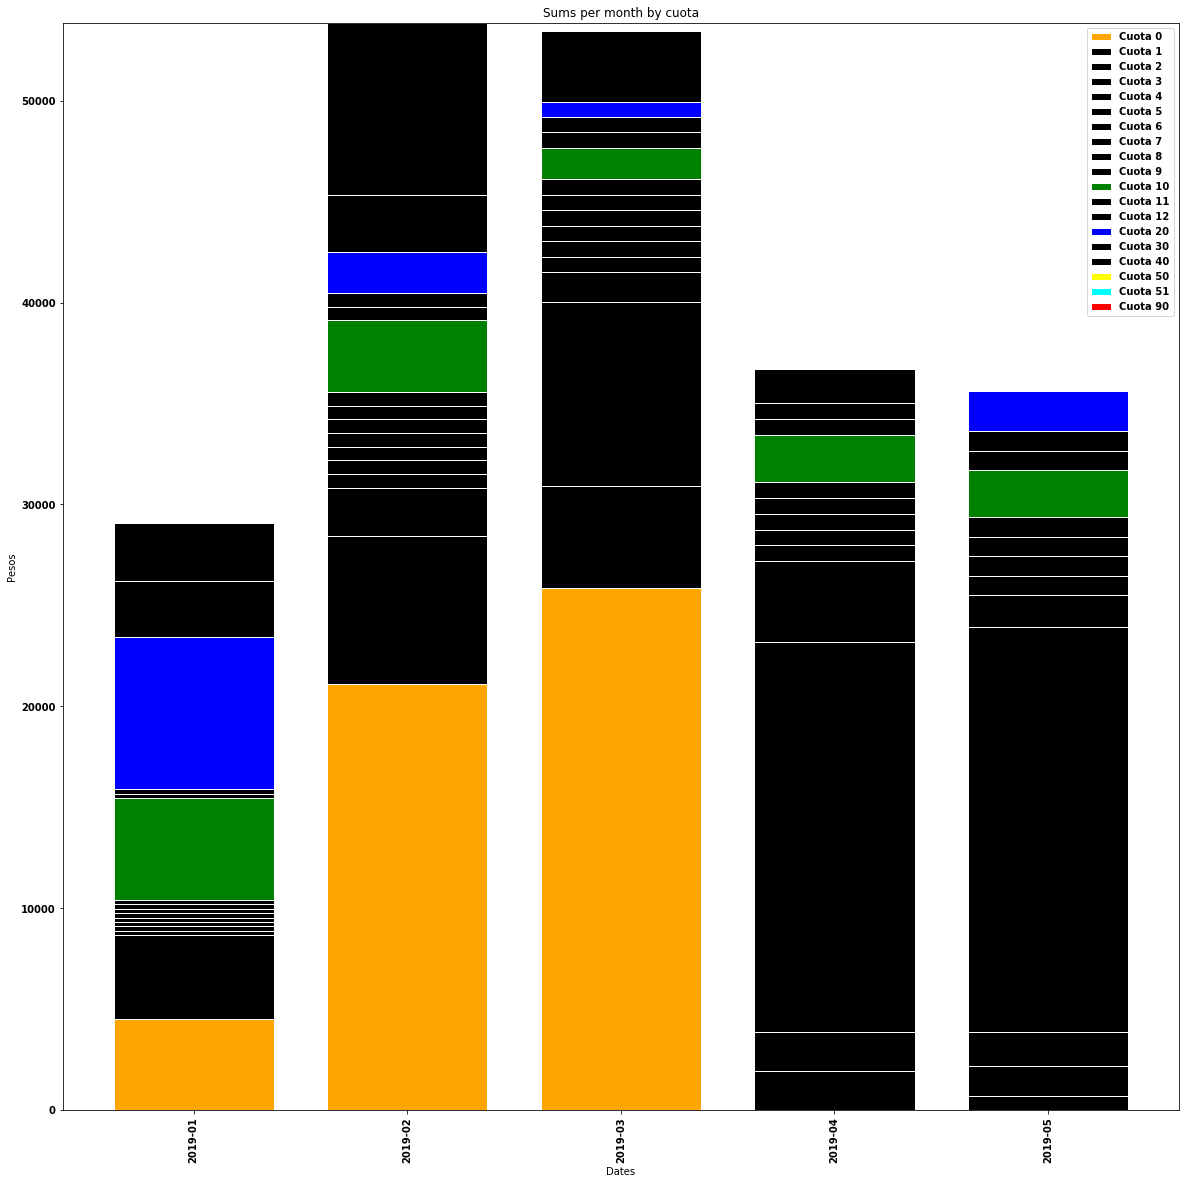

In [16]:
# figure size
plt.rcParams['figure.figsize'] = [20, 20]
# y-axis in bold
rc('font', weight='bold')

df_2019 = new_df['2019-01':'2019-05']

# Heights
indx = df_2019.index.astype(str)
bar0 = df_2019.Cuota_0.fillna(0)
bar1 = df_2019.Cuota_1.fillna(0)
bar2 = df_2019.Cuota_2.fillna(0)
bar3 = df_2019.Cuota_3.fillna(0)
bar4 = df_2019.Cuota_4.fillna(0)
bar5 = df_2019.Cuota_5.fillna(0)
bar6 = df_2019.Cuota_6.fillna(0)
bar7 = df_2019.Cuota_7.fillna(0)
bar8 = df_2019.Cuota_8.fillna(0)
bar9 = df_2019.Cuota_9.fillna(0)
bar10 = df_2019.Cuota_10.fillna(0)
bar11 = df_2019.Cuota_11.fillna(0)
bar12 = df_2019.Cuota_12.fillna(0)
bar20 = df_2019.Cuota_20.fillna(0)
bar30 = df_2019.Cuota_30.fillna(0)
bar40 = df_2019.Cuota_40.fillna(0)
bar50 = df_2019.Cuota_50.fillna(0)
bar51 = df_2019.Cuota_51.fillna(0)
bar90 = df_2019.Cuota_90.fillna(0)  
 
# Names of group and bar width
names = indx
barWidth = 0.75
 
# Create orange bars
p1 = plt.bar(indx, bar0, color='orange', edgecolor='white', width=barWidth)
# Create black bars (middle), on top of the first ones
p2 = plt.bar(indx, bar1, bottom=bar0, color='black', edgecolor='white', width=barWidth)
# Create black bars (middle)
p3 = plt.bar(indx, bar2, bottom=bar1+bar0, color='black', edgecolor='white', width=barWidth)
# Create black bars (middle)
p4 = plt.bar(indx, bar3, bottom=bar2+bar1+bar0, color='black', edgecolor='white', width=barWidth)
# Create black bars (middle)
p5 = plt.bar(indx, bar4, bottom=bar3+bar2+bar1+bar0, color='black', edgecolor='white', width=barWidth)
# Create black bars (top)
p6 = plt.bar(indx, bar5, bottom=bar4+bar3+bar2+bar1+bar0, color='black', edgecolor='white', width=barWidth)
# Create black bars (top)
p7 = plt.bar(indx, bar6, bottom=bar5+bar4+bar3+bar2+bar1+bar0, color='black', edgecolor='white', width=barWidth)
# Create black bars (top)
p8 = plt.bar(indx, bar7, bottom=bar6+bar5+bar4+bar3+bar2+bar1+bar0, color='black', edgecolor='white', width=barWidth)
# Create black bars (top)
p9 = plt.bar(indx, bar8, bottom=bar7+bar6+bar5+bar4+bar3+bar2+bar1+bar0, color='black', edgecolor='white', width=barWidth)
# Create black bars (top)
p10 = plt.bar(indx, bar9, bottom=bar8+bar7+bar6+bar5+bar4+bar3+bar2+bar1+bar0, color='black', edgecolor='white', width=barWidth)
# Create green bars (top)
p11 = plt.bar(indx, bar10, bottom=bar9+bar8+bar7+bar6+bar5+bar4+bar3+bar2+bar1+bar0, color='green', edgecolor='white', width=barWidth)
# Create black bars (top)
p12 = plt.bar(indx, bar11, bottom=bar10+bar9+bar8+bar7+bar6+bar5+bar4+bar3+bar2+bar1+bar0, color='black', edgecolor='white', width=barWidth)
# Create black bars (top)
p13 = plt.bar(indx, bar12, bottom=bar11+bar10+bar9+bar8+bar7+bar6+bar5+bar4+bar3+bar2+bar1+bar0, color='black', edgecolor='white', width=barWidth)
# Create blue bars (top)
p14 = plt.bar(indx, bar20, bottom=bar12+bar11+bar10+bar9+bar8+bar7+bar6+bar5+bar4+bar3+bar2+bar1+bar0, color='blue', edgecolor='white', width=barWidth)
# Create black bars (top)
p15 = plt.bar(indx, bar30, bottom=bar20+bar12+bar11+bar10+bar9+bar8+bar7+bar6+bar5+bar4+bar3+bar2+bar1+bar0, color='black', edgecolor='white', width=barWidth)
# Create black bars (top)
p16 = plt.bar(indx, bar40, bottom=bar30+bar20+bar12+bar11+bar10+bar9+bar8+bar7+bar6+bar5+bar4+bar3+bar2+bar1+bar0, color='black', edgecolor='white', width=barWidth)
# Create yellow bars (top)
p17 = plt.bar(indx, bar50, bottom=bar40+bar30+bar20+bar12+bar11+bar10+bar9+bar8+bar7+bar6+bar5+bar4+bar3+bar2+bar1+bar0, color="yellow", edgecolor='white', width=barWidth)
# Create cyan bars (top)
p18 = plt.bar(indx, bar51, bottom=bar50+bar40+bar30+bar20+bar12+bar11+bar10+bar9+bar8+bar7+bar6+bar5+bar4+bar3+bar2+bar1+bar0, color='cyan', edgecolor='white', width=barWidth)
# Create red bars (top)
p19 = plt.bar(indx, bar90, bottom=bar51+bar50+bar40+bar30+bar20+bar12+bar11+bar10+bar9+bar8+bar7+bar6+bar5+bar4+bar3+bar2+bar1+bar0, color='red', edgecolor='white', width=barWidth)

plt.ylabel('Pesos')
plt.title('Sums per month by cuota')
# Custom X axis
plt.xlabel('Dates')
plt.ylabel('Pesos')
plt.xticks(indx, rotation=90)
plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0], p6[0], p7[0], p8[0], p9[0], p10[0], p11[0], p12[0], p13[0], p14[0], p15[0], p16[0], p17[0], p18[0], p19[0]), ('Cuota 0', 'Cuota 1', 'Cuota 2', 'Cuota 3', 'Cuota 4', 'Cuota 5', 'Cuota 6', 'Cuota 7', 'Cuota 8', 'Cuota 9', 'Cuota 10', 'Cuota 11', 'Cuota 12', 'Cuota 20', 'Cuota 30', 'Cuota 40', 'Cuota 50', 'Cuota 51', 'Cuota 90'))
# Show graphic
plt.show()

In [17]:
# Now, that strange month in 2016 (the previous outlier), shows 57 payments; The previous dataset showed only 8 payments
clean_df.MCC_IMPORTE['2016-4'].count()

57

In [18]:
# ... with and average of $463 pesos; The previous dataset showed $17,546
clean_df.MCC_IMPORTE['2016-4'].mean()

463.37385964912283

In [19]:
# There were 84 payments made in April, 2019; The previous dataset showed 508.
clean_df.MCC_IMPORTE['2019-4'].count()

84

In [20]:
# The average amount of the payment was $437; The previous dataset showed $1,550.
clean_df.MCC_IMPORTE['2019-4'].mean()

437.2083333333333

In [21]:
# Max value overall $18,122; The previous dataset showed $138,440
clean_df.MCC_IMPORTE.max()

18122.22

In [22]:
# Here you can see the largest payment in the data set was made 11 March 2019, Cuota 0.
clean_df['2019-03':'2019-03'].head(10)

,MCC_OBN_ID,MCC_IMPORTE,OBN_CUOTA,Period
FECHA_PAGO,,,,
2019-03-19,20190000000038004248,222.66,10,2019-03
2019-03-04,20190000000038256029,7756.38,0,2019-03
2019-03-20,20190000000033130570,282.38,1,2019-03
2019-03-20,20190000000033130570,10.45,1,2019-03
2019-03-11,20190000000035054099,18122.22,0,2019-03
2019-03-11,20190000000035711725,42.78,2,2019-03
2019-03-11,20190000000036696877,1099.22,2,2019-03
2019-03-11,20190000000052375044,544.28,8,2019-03
2019-03-11,20190000000029898087,123.93,1,2019-03
